In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

In [73]:
df=pd.read_csv('DM2425_ABCDEats_DATASET.csv',delimiter=',')

# Drop Dublicates

We need to eliminate duplicates to prevent further issues, especially with the index setting

In [74]:
df.duplicated().sum()

np.int64(13)

In [75]:
df=df.drop_duplicates()
# Count the number of remaining duplicate rows in the DataFrame after dropping duplicates
df.duplicated().sum()

np.int64(0)

# Set costumer_id as the index

In [76]:
df.set_index('customer_id', inplace=True)

## Fixing variables

**costumer_age**

Fill missing values with median

In [77]:
df['customer_age'].isna().sum()

np.int64(727)

In [78]:
df['customer_age'] = df['customer_age'].fillna(df['customer_age'].median())
df['customer_age'].isna().sum()

np.int64(0)

**costumer_region**

Replace the value of '-' with 'Unknown' to enhance the interpretation of the feature

In [79]:
df.loc[:, 'customer_region'] = df['customer_region'].replace('-', 'Unknown')

**product_count**

There is an extreme product count value with '92ced2dcb9' index, so we will transform it into a high value

In [80]:
df.loc['92ced2dcb9','product_count']=100

**first_order**

Fill missing values with median

In [81]:
df['first_order'] = df['first_order'].fillna(df['first_order'].median())

**last_promo**

Replace the value of '-' with 'no_promotion_used' to enhance the interpretation of the feature

In [82]:
df['last_promo'] = df['last_promo'].replace('-', 'no_promotion_used')

**HR_0**

Drop the column labeled "HR_0" because it contains only zeros.

In [83]:
df.drop(columns=['HR_0'], inplace=True)

#Fixing inconsistencies

Eliminate rows where there are inconsistencies

In [84]:
df['sum_HR']=df['HR_1']+df['HR_2']+df['HR_3']+df['HR_4']+df['HR_5']+df['HR_6']+df['HR_7']+df['HR_8']+df['HR_9']+df['HR_10']+df['HR_11']+df['HR_12']+df['HR_13']+df['HR_14']+df['HR_15']+df['HR_16']+df['HR_17']+df['HR_18']+df['HR_19']+df['HR_20']+df['HR_21']+df['HR_22']+df['HR_23']
df['sum_DOW']=df['DOW_0']+df['DOW_1']+df['DOW_2']+df['DOW_3']+df['DOW_4']+df['DOW_5']+df['DOW_6']
df['inc_0']=(df['sum_HR']!=df['sum_DOW'])
df['inc_2']=(df['product_count']==0)
df = df.loc[~(df['inc_0'] | df['inc_2'])]
df = df.drop(columns=['sum_HR', 'sum_DOW', 'inc_0', 'inc_2'])

# New variables

**Total_Spent**

In [85]:
cuisine = [col for col in df.columns if col.startswith('CUI_')]

In [86]:
df['Total_Spent']=df[cuisine].sum(axis=1)

Deal with extreme outliers

In [87]:
df = df.drop('92ced2dcb9', axis=0)
df.loc['249ba584d3','CUI_Asian']=500
df.loc['8d65421423','CUI_Japanese']=590
df['Total_Spent']=df[cuisine].sum(axis=1)

**Order_Count**

In [88]:
df['order_count']=df['DOW_0']+df['DOW_1']+df['DOW_2']+df['DOW_3']+df['DOW_4']+df['DOW_5']+df['DOW_6']

**Diversity_Cuisine**

In [89]:
df['Diversity_Cuisine'] = (df[cuisine] > 0).sum(axis=1)
df['Diversity_Cuisine'] = df['order_count']/df['Diversity_Cuisine']

**Costumer_time**

In [90]:
df['costumer_time']=df['last_order']-df['first_order']

**Intensity_of_Activity**

In [91]:
df['Intensity_of_Activity'] = df['costumer_time'] / df['order_count']

**Customer_Loyalty**

In [92]:
df['Customer_loyalty'] = df['vendor_count'] / df['order_count']

**Product_Intensity**

In [93]:
df['product_intensity'] = df['product_count'] / df['order_count']

**Day_Week_Spread**

In [94]:
days = [col for col in df.columns if col.startswith('DOW_')]

In [95]:
df['Day_Week_Spread'] = df.loc[:,days].var(axis=1)

**hour_spread**

In [96]:
hours=[col for col in df.columns if col.startswith('HR_')]

In [97]:
df['hour_spread'] = df.loc[:,hours].var(axis=1)

In [98]:
df.to_csv('df_Clean.csv')

# Normalize data

In [99]:
#Select numeric features
metric_features = df.select_dtypes(include=['number']).columns.tolist()

In [100]:
# Normalize numeric data with Min-Max scaler
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df[metric_features])
df[metric_features] = scaled_feat

In [101]:
#Select categorical features
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [102]:
def encode_by_proportion(df,column_name):
    category_proportions = df[column_name].value_counts(normalize=True)

    df[column_name] = df[column_name].map(category_proportions)
    
    return df

In [103]:
ohc_df = df.copy()
ohc_df=ohc_df[categorical_features]
for i in ohc_df.columns:
    ohc_df=encode_by_proportion(ohc_df,i)
ohc_df

,customer_region,last_promo,payment_method
customer_id,,,
1b8f824d5e,0.277738,0.198337,0.191890
5d272b9dcb,0.296066,0.141422,0.191890
f6d1b2ba63,0.308961,0.141422,0.177718
180c632ed8,0.308961,0.198337,0.191890
4eb37a6705,0.308961,0.523663,0.191890
...,...,...,...
f4e366c281,0.296066,0.136578,0.191890
f6b6709018,0.296066,0.198337,0.191890
f74ad8ce3f,0.296066,0.523663,0.191890


# PCA analisys

In [104]:
X = df[metric_features]
pca = PCA().fit(X)

In [105]:
PCA_s=pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)
PCA_s.head(20)

,Eigenvalue,Difference,Proportion,Cumulative
1,0.158238,0.000000,0.412440,0.412440
2,0.085737,-0.072501,0.223470,0.635909
3,0.043988,-0.041749,0.114652,0.750561
4,0.020823,-0.023165,0.054274,0.804836
5,0.011896,-0.008928,0.031005,0.835841
6,0.007862,-0.004033,0.020492,0.856334
7,0.004534,-0.003328,0.011819,0.868152
8,0.003645,-0.000890,0.009500,0.877652
9,0.003178,-0.000467,0.008283,0.885935
10,0.002890,-0.000288,0.007532,0.893467


In [106]:
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=X.columns)
print(loadings)

                               PC1       PC2       PC3       PC4       PC5  \
customer_age              0.001957  0.004013 -0.006751 -0.001034  0.999811   
vendor_count              0.103836  0.007049  0.033608 -0.317627 -0.002038   
product_count             0.095717  0.009164 -0.065706 -0.260966 -0.000830   
is_chain                  0.067863  0.003501 -0.039801 -0.188995 -0.003187   
first_order              -0.446194  0.690843 -0.145226 -0.025411 -0.003649   
last_order                0.359148  0.719276  0.202752  0.024877 -0.001443   
CUI_American              0.029061  0.002160 -0.020637 -0.058330  0.002088   
CUI_Asian                 0.021611  0.005565  0.001693 -0.067766  0.006139   
CUI_Beverages             0.011955  0.000563  0.000317 -0.047123 -0.001568   
CUI_Cafe                  0.007447  0.001285 -0.009383 -0.027572  0.000715   
CUI_Chicken Dishes        0.006694 -0.000105 -0.002437 -0.020653 -0.000323   
CUI_Chinese               0.006541  0.000507 -0.004085 -0.021039

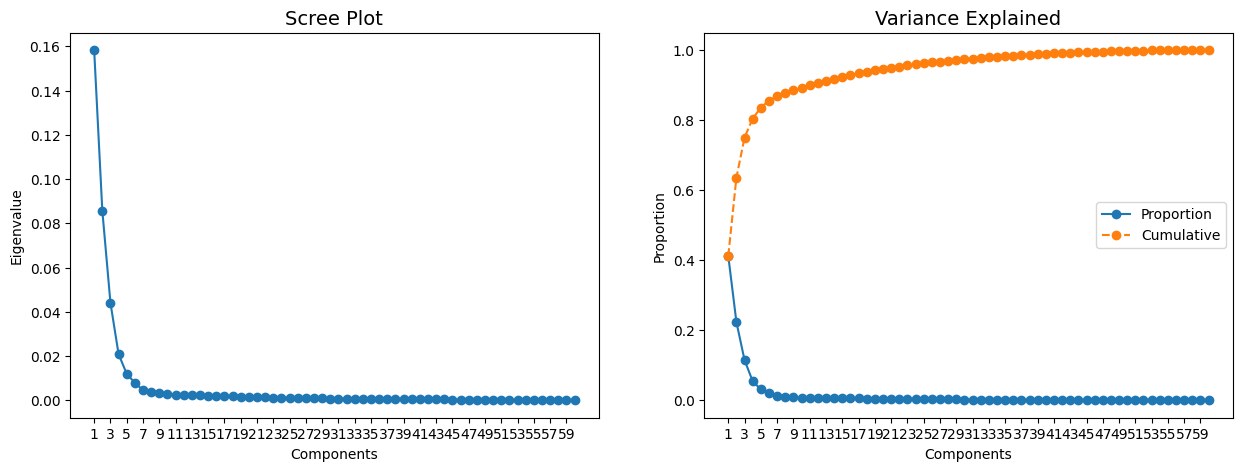

In [107]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

We decided to establish a threshold of 85% cumulative variance, so we will retain the first 6 components

In [108]:
#Retain the first 6 components
pca = PCA(n_components=6)
pca_feat = pca.fit_transform(df[metric_features])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
#Create the dataframe "df_PCA" with the PC`s and the normalized categorical features
df_PCA = pd.DataFrame(pca_feat, index=df.index, columns=pca_feat_names)
df_PCA=pd.concat([df_PCA,ohc_df],axis=1)
#Normalize the PC features
metric_features1 = df_PCA.select_dtypes(include=['number']).columns.tolist()
scaled_feat = scaler.fit_transform(df_PCA[metric_features1])
df_PCA = scaled_feat
df_PCA = pd.DataFrame(df_PCA, index=df.index, columns=metric_features1)

# Outlier removing using DBSCAN

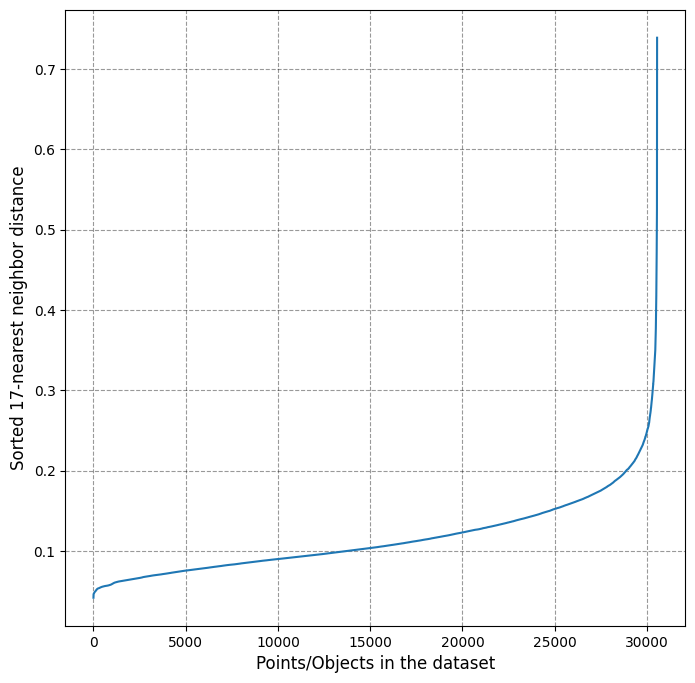

In [109]:
from sklearn.neighbors import NearestNeighbors
def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()


k = 2 * df_PCA.shape[-1] - 1 # k=2*{dim(dataset)} - 1
get_kdist_plot(X=df_PCA, k=k)

In [110]:
from sklearn.cluster import DBSCAN
epsilon = 0.2  
min_samples = 20  
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(df_PCA)

In [111]:
df_PCA['Cluster'] = clusters

In [112]:
df_PCA['Cluster'].value_counts()

Cluster
 6    9604
 3    7303
 0    5389
 1    4433
 2    1193
 7     920
 4     634
 5     565
-1     513
Name: count, dtype: int64

In [113]:
df_PCA = df_PCA[df_PCA['Cluster'] != -1].reset_index(drop=True)

In [114]:
df_PCA.to_csv('df_PCA.csv')